In [1]:
# [Description] Import necessary libraries.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import itertools as iters

In [2]:
# [Description] Define a function that generates a simulated bank portfolio data.

def generate_data(nBanks, nAssets, tPeriods=1):
    
    data_dict = {}
    
    for t in range(1, tPeriods+1):
        
        idx = [f'b{n}' for n in range(1, nBanks+1)]
        col = [f'a{k}' for k in range(1, nAssets+1)]
        
        data = np.random.rand(nBanks, nAssets)
        
        data_dict[t] = pd.DataFrame(data, index=idx, columns=col)
    
    return data_dict

In [3]:
# [Description] Define a function that ensures the sum of rows or columns of a given DataFrame equals 1 by adjusting the values proportionally.

def normalize(arr, axis=1):

    sums = np.sum(arr, axis=axis)
    
    if axis == 0:
        return arr / np.expand_dims(sums, axis=0)
    
    elif axis == 1:
        return arr / np.expand_dims(sums, axis=1)
    
    else:
        raise ValueError("Invalid axis. Axis should be 0 or 1.")

        
def normalize_timewise(dict_array, axis=1):
    
    data_dict = {}
    
    for t in dict_array.keys():
        
        data_dict[t] = normalize(dict_array[t], axis=axis)
    
    return data_dict


def distance_list(mat):
    
    nBanks = len(mat.index)
    idx = np.triu_indices(nBanks, k=1)
    
    distances = mat.values[idx]
    
    return distances

In [5]:
# [Description] Generate an arbitrary loan portfolio matrix for simulation.

N = 20 # the number of banks
K = 15 # the number of assets
T = 20 # the list of time index

A = generate_data(N, K, T) # A list of loan portfolio matrix (not normalized)
W = normalize_timewise(A)  # A list of loan portfolio matrix

## **1. Similarity Measures**

### **1.1. The Generalized Jaccard Similarity**

$$ GenJacc^{t}_{i,j} = \frac{ \sum\limits^{K}_{k=1} \min(w^{t}_{i,k}, w^{t}_{j,k}) }{ \sum\limits^{K}_{k=1} \max(w^{t}_{i,k}, w^{t}_{j,k}) } \tag{1}$$

In [56]:
# [Description] Define a function measuring the portfolio similarity - 1 : The Generalized Jaccard Similarity.

def genJacc(w):
    
    banks = w.index
    assets = w.columns

    genJaccMatrix = pd.DataFrame()

    for bankI in banks:
        
        for bankJ in banks:
        
            sumMin = 0
            sumMax = 0

            for k in assets:

                wMin = np.min([w.loc[bankI, k], w.loc[bankJ, k]])
                wMax = np.max([w.loc[bankI, k], w.loc[bankJ, k]])

                sumMin += wMin
                sumMax += wMax

            genJacc = sumMin / sumMax
            genJaccMatrix.loc[bankI, bankJ] = genJacc
    
    return genJaccMatrix

### **1.2. The Euclidean Distance**

$$ Distance^{t}_{i, j} = \sqrt{ \sum\limits^{K}_{k=1} (w^{t}_{i,k} - w^{t}_{j,k})^2 } \tag{2} $$

$$ SimDist^{t}_{i, j} = \frac{1}{1 + Distance^{t}_{i,j}} \tag{3} $$

In [65]:
# [Description] Define a function measuring the portfolio similarity - 2 : The Similarity Distance.

def simDist(w):

    banks = w.index
    assets = w.columns
    
    simDistMatrix = pd.DataFrame()
    
    for bankI in banks:
        
        for bankJ in banks:
        
            dist = (w.loc[bankI, :] - w.loc[bankJ, :]) ** 2

            sumDist = np.sqrt(dist.sum())

            simDistMatrix.loc[bankI, bankJ] = 1 / (1 + sumDist)
    
    return simDistMatrix

### **1.3. The Connectedness of Differenct Assets**

$$Connected^{t}_{i,j} = \frac{ \sum\limits_{k \in \mathcal{H}^{t}_{i,j}} (w^{t}_{i,k} A^{t}_{i} + w^{t}_{j,k} A^{t}_{j}) }{ A^{t}_{i} + A^{t}_{j} } \tag{4}$$

In [69]:
# [Description] Define a function measuring the portfolio similarity - 3 : The Connectedness.

def connected(w, a):

    pValue = a.sum(axis=1) # loan portfolio value of banks
    banks = w.index
    assets = w.columns
    
    conMatrix = pd.DataFrame()
    
    for bankI in banks:
        
        Ai = pValue.loc[bankI]
        
        for bankJ in banks:
        
            Aj = pValue.loc[bankJ]

            sumCon = 0

            for k in assets:
                
                wi = w.loc[bankI, k]
                wj = w.loc[bankJ, k]

                if wi * wj > 0:
                    sumCon += wi * Ai + wj * Aj
            
            conMatrix.loc[bankI, bankJ] = sumCon / (Ai + Aj)
    
    return conMatrix

### **1.4. The Cosine Similarity**

$$ CoSim^{t}_{i,j} = \frac{ \sum\limits^{K}_{k=1} w^{t}_{i,k} w^{t}_{j,k} }{ \sqrt{\sum\limits^{K}_{k=1} (w^{t}_{i,k})^2} \sqrt{\sum\limits^{K}_{k=1} (w^{t}_{j,k})^2} } \tag{5} $$

In [79]:
# [Description] Define a function measuring the portfolio similarity - 3 : The Cosine Similarity.

def coSim(w):

    banks = w.index
    assets = w.columns
    
    coSimMatrix = pd.DataFrame()
    
    for bankI in banks:
        
        for bankJ in banks:
        
            sumx = w.loc[bankI, :] * w.loc[bankJ, :]
            sumx = sumx.sum()
            
            sumi = w.loc[bankI, :] ** 2
            sumi = sumi.sum()
            
            sumj = w.loc[bankJ, :] ** 2
            sumj = sumj.sum()

            coSim = sumx / (np.sqrt(sumi) * np.sqrt(sumj))

            coSimMatrix.loc[bankI, bankJ] = coSim
    
    return coSimMatrix

## **2. Visualization and Descriptive Statistics**

### **2.1. Similarity over Time**

In [82]:
# [Description] Construct a dataset of similarity measures over time.

def indices_over_time(A, W, method='mean'):
    
    periods = W.keys()
    
    data = pd.DataFrame()
    
    for t in periods:
        
        w = W[t]
        a = A[t]
        
        if method == 'mean':
            GJ = np.mean(distance_list(genJacc(w)))
            SD = np.mean(distance_list(simDist(w)))
            CN = np.mean(distance_list(connected(w, a)))
            CS = np.mean(distance_list(coSim(w)))
        elif method == 'median':
            GJ = np.median(distance_list(genJacc(w)))
            SD = np.median(distance_list(simDist(w)))
            CN = np.median(distance_list(connected(w, a)))
            CS = np.median(distance_list(coSim(w)))
        else:
            raise ValueError("Invalid method. Method should be 'mean' or 'median'.")
            
        data.loc[t, ['genJacc', 'simDist', 'connected', 'coSim']] = [GJ, SD, CN, CS]
    
    return data

In [83]:
df_mean = indices_over_time(A, W, method='mean')
df_median = indices_over_time(A, W, method='median')

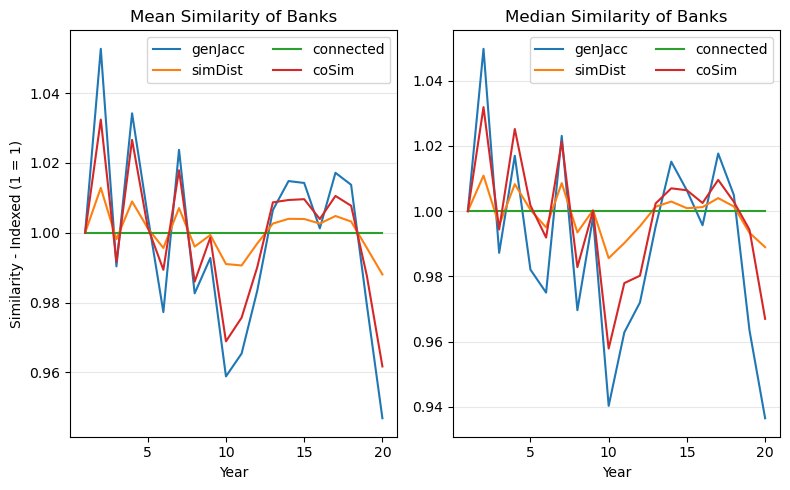

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].plot(df_mean / df_mean.iloc[0], label=df_mean.columns)
ax[1].plot(df_median / df_median.iloc[0], label=df_median.columns)

ax[0].set_title('Mean Similarity of Banks')
ax[1].set_title('Median Similarity of Banks')

ax[0].set_ylabel(f'Similarity - Indexed ({df_mean.index[0]} = 1)')

for a in ax:
    a.legend(ncol=2)
    a.set_xlabel('Year')
    a.grid(axis='y', color='lightgray', alpha=0.5)

fig.tight_layout()

### **2.2. Pairwise Correlation between the Similarity Indicies**

In [87]:
df_mean[['genJacc', 'simDist', 'coSim']].corr()

,genJacc,simDist,coSim
genJacc,1.000000,0.994228,0.989955
simDist,0.994228,1.000000,0.992506
coSim,0.989955,0.992506,1.000000


In [88]:
df_median[['genJacc', 'simDist', 'coSim']].corr()

,genJacc,simDist,coSim
genJacc,1.000000,0.961431,0.947667
simDist,0.961431,1.000000,0.973397
coSim,0.947667,0.973397,1.000000


### **2.3. Kernel Density of Similarity Measures**